### Inference Model Denoising & Classification


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from AdaptiveFilterWrapper import adapfilt_modeler

Using TensorFlow backend.


In [2]:
def read_adapfilt_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model

- load model

In [3]:
lms_model = read_adapfilt_model("LMS_adapfilt_model_afdb.pkl")
nlms_model = read_adapfilt_model("NLMS_adapfilt_model_afdb.pkl")
rls_model = read_adapfilt_model("RLS_adapfilt_model_afdb.pkl")

In [4]:
cnn_lms_model = models.load_model('CNN_Classification_model_lms.h5')
cnn_nlms_model = models.load_model('CNN_Classification_model_nlms.h5')
cnn_rls_model = models.load_model('CNN_Classification_model_rls.h5')

In [5]:
label_names = ['AF', 'N']

In [6]:
dataset_folder ="dataset/"
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("AFDB_pasien_") > -1:
        filenames.append(filename)

In [7]:
filenames

['AFDB_pasien_AF_Ibu EEM.csv',
 'AFDB_pasien_AF_Ibu Halima.csv',
 'AFDB_pasien_AF_Ibu Yaya.csv',
 'AFDB_pasien_AF_Pak Dawin.csv',
 'AFDB_pasien_AF_Pak Ohan.csv',
 'AFDB_pasien_AF_Pak Wardoyo.csv',
 'AFDB_pasien_Normal_Fikar.csv',
 'AFDB_pasien_Normal_Hari.csv',
 'AFDB_pasien_Normal_Ikhsan.csv',
 'AFDB_pasien_Normal_Imam.csv',
 'AFDB_pasien_Normal_Putu.csv',
 'AFDB_pasien_Normal_Zein.csv']

- load inference data

In [8]:
inference_data = {}
for name in filenames:
    infer = pd.read_csv(dataset_folder + name, header=None)
    inference_data[name] = infer

In [9]:
inference_data['AFDB_pasien_AF_Ibu EEM.csv'].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.735847,0.810470,0.834570,0.817344,0.775643,0.728654,0.691847,0.674867,0.678770,0.697589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000651,1.078669,1.075988,1.005982,0.894077,0.770221,0.660691,0.582774,0.541611,0.531473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.349208,0.383967,0.394341,0.384677,0.363018,0.338588,0.318951,0.308876,0.309087,0.316957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.332000,0.365133,0.375185,0.366316,0.346175,0.323504,0.305442,0.296430,0.297050,0.304702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.372790,0.390878,0.372805,0.323730,0.254204,0.177298,0.105398,0.047643,0.008490,-0.012247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
mat_infer_data = {}
for name in filenames:
    infer_df = inference_data[name]
    mat_infer_data[name] = infer_df.values

- Apply denoising model to inference data

In [11]:
lms_den_res = {}
nlms_den_res = {}
rls_den_res = {}
for name in filenames:
    lms_den_res[name] = lms_model.transform(mat_infer_data[name])
    nlms_den_res[name] = nlms_model.transform(mat_infer_data[name])
    rls_den_res[name] = rls_model.transform(mat_infer_data[name])
    print("denoising data - %s" % name)

denoising data - AFDB_pasien_AF_Ibu EEM.csv
denoising data - AFDB_pasien_AF_Ibu Halima.csv
denoising data - AFDB_pasien_AF_Ibu Yaya.csv
denoising data - AFDB_pasien_AF_Pak Dawin.csv
denoising data - AFDB_pasien_AF_Pak Ohan.csv
denoising data - AFDB_pasien_AF_Pak Wardoyo.csv
denoising data - AFDB_pasien_Normal_Fikar.csv
denoising data - AFDB_pasien_Normal_Hari.csv
denoising data - AFDB_pasien_Normal_Ikhsan.csv
denoising data - AFDB_pasien_Normal_Imam.csv
denoising data - AFDB_pasien_Normal_Putu.csv
denoising data - AFDB_pasien_Normal_Zein.csv


In [29]:
def plot_denoising_test(y, x, model='lms', fs=250):
    times = np.arange(y.shape[0]) / fs * 1000 
    # show results
    plt.figure(figsize=(6,4))
    plt.title("Adaptation Result %s - Inference Dataset" % model.upper())
    plt.xlabel("time (ms)")
    plt.plot(times, y,"b", label="y - denoised signal")
    plt.plot(times, x,"g", label="x - original signal")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

- Check result

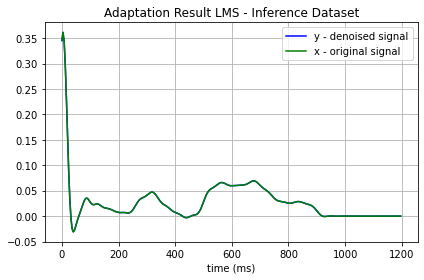

In [30]:
name = 'AFDB_pasien_AF_Ibu EEM.csv'
idx = 13

y = lms_den_res[name][idx]
x = mat_infer_data[name][idx]

plot_denoising_test(y, x, model='lms')

- Reshape matrix result of denoising

In [14]:
lms_mat_3d = {}
nlms_mat_3d = {}
rls_mat_3d = {}
for name in filenames:
    lms_mat_3d[name] = lms_den_res[name].reshape(len(lms_den_res[name]), lms_den_res[name].shape[1], 1)
    nlms_mat_3d[name] = nlms_den_res[name].reshape(len(nlms_den_res[name]), nlms_den_res[name].shape[1], 1)
    rls_mat_3d[name] = rls_den_res[name].reshape(len(rls_den_res[name]), rls_den_res[name].shape[1], 1)


- Apply to CNN model

In [15]:
cnn_lms_classif_result = {}
cnn_nlms_classif_result = {}
cnn_rls_classif_result = {}
for name in filenames:
    cnn_lms_classif_result[name] = cnn_lms_model.predict(lms_mat_3d[name])
    cnn_nlms_classif_result[name] = cnn_nlms_model.predict(nlms_mat_3d[name])
    cnn_rls_classif_result[name] = cnn_rls_model.predict(rls_mat_3d[name])
    print("predicting data - %s" % name)

predicting data - AFDB_pasien_AF_Ibu EEM.csv
predicting data - AFDB_pasien_AF_Ibu Halima.csv
predicting data - AFDB_pasien_AF_Ibu Yaya.csv
predicting data - AFDB_pasien_AF_Pak Dawin.csv
predicting data - AFDB_pasien_AF_Pak Ohan.csv
predicting data - AFDB_pasien_AF_Pak Wardoyo.csv
predicting data - AFDB_pasien_Normal_Fikar.csv
predicting data - AFDB_pasien_Normal_Hari.csv
predicting data - AFDB_pasien_Normal_Ikhsan.csv
predicting data - AFDB_pasien_Normal_Imam.csv
predicting data - AFDB_pasien_Normal_Putu.csv
predicting data - AFDB_pasien_Normal_Zein.csv


- Check result

In [31]:
def plot_cnn_result(data, label='lms', confidence=0.0, fs = 250):
    times = np.arange(data.shape[0]) / fs * 1000 
    confidence = confidence*100
    # show results
    plt.figure(figsize=(6,4))
    plt.title("Classification Result : %s - confidence (%.2f%%)" % (label, confidence))
    plt.xlabel("time (ms)")
    plt.plot(times, data,"g", label="signal")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

In [17]:
pred_result = []
for name in filenames :
    cnn_res = cnn_rls_classif_result[name] # ubah ke lms, nlms dan rls
    print("\n\n\nPrediction Result - %s\n" % name)
    for i, res in enumerate(cnn_res):
        predicted_id = np.argmax(res)
        label = label_names[predicted_id]
        confidence = res[predicted_id]
        label = label if confidence > 0.40 else '?' # threshold for confidence level , set to 70%
        pred_result.append([name, i, label, confidence])
        
        print('%s \t index - %d \t %s \t %.2f %%' % (name, i, label, confidence*100))




Prediction Result - AFDB_pasien_AF_Ibu EEM.csv

AFDB_pasien_AF_Ibu EEM.csv 	 index - 0 	 AF 	 99.41 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 1 	 AF 	 89.45 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 2 	 AF 	 72.92 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 3 	 AF 	 93.93 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 4 	 N 	 95.98 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 5 	 N 	 92.93 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 6 	 AF 	 58.74 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 7 	 N 	 98.18 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 8 	 AF 	 99.73 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 9 	 N 	 62.95 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 10 	 N 	 85.13 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 11 	 AF 	 67.08 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 12 	 N 	 68.12 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 13 	 AF 	 54.54 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 14 	 N 	 65.82 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 15 	 N 	 68.21 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 16 	 N 	 99.99 %
AFDB_pasien_AF_Ibu EEM.csv 	 inde

In [46]:
name = "AFDB_pasien_Normal_Hari.csv"
idx = np.where(name == np.array(pred_result)[:, 0])[0]

In [48]:
idx[0]

3249

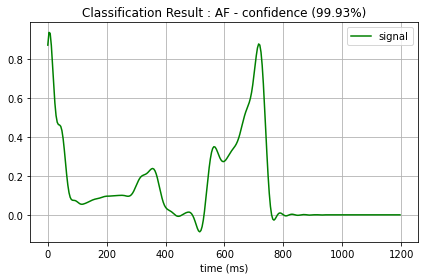

In [50]:
res = pred_result[idx[3]]
data = lms_den_res[name][res[1]]
plot_cnn_result(data, res[2], res[3])

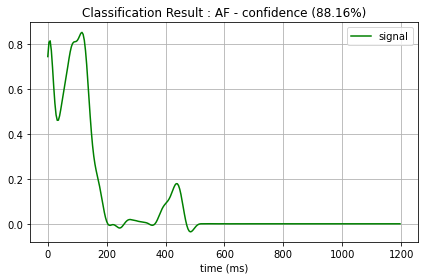

In [51]:
res = pred_result[idx[-3]]
data = lms_den_res[name][res[1]]
plot_cnn_result(data, res[2], res[3])

In [29]:
pred_result_df = pd.DataFrame(pred_result, columns=['filename', 'idx', 'label', 'confidence'])

In [30]:
pred_result_df.head()

,filename,idx,label,confidence
0,AFDB_pasien_AF_Ibu EEM.csv,0,AF,0.994071
1,AFDB_pasien_AF_Ibu EEM.csv,1,AF,0.894520
2,AFDB_pasien_AF_Ibu EEM.csv,2,AF,0.729211
3,AFDB_pasien_AF_Ibu EEM.csv,3,AF,0.939304
4,AFDB_pasien_AF_Ibu EEM.csv,4,N,0.959793


In [31]:
for name in filenames:
    print(name)
    count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
    for key in count :
        print("%s \t: %d" % (key, count[key]))
    print('\n')

AFDB_pasien_AF_Ibu EEM.csv
AF 	: 284
N 	: 77


AFDB_pasien_AF_Ibu Halima.csv
N 	: 14
AF 	: 2


AFDB_pasien_AF_Ibu Yaya.csv
AF 	: 428
N 	: 61


AFDB_pasien_AF_Pak Dawin.csv
N 	: 432
AF 	: 264


AFDB_pasien_AF_Pak Ohan.csv
AF 	: 520
N 	: 84


AFDB_pasien_AF_Pak Wardoyo.csv
N 	: 369
AF 	: 174


AFDB_pasien_Normal_Fikar.csv
AF 	: 505
N 	: 35


AFDB_pasien_Normal_Hari.csv
AF 	: 474
N 	: 25


AFDB_pasien_Normal_Ikhsan.csv
AF 	: 474
N 	: 165


AFDB_pasien_Normal_Imam.csv
AF 	: 198
N 	: 124


AFDB_pasien_Normal_Putu.csv
AF 	: 794
N 	: 54


AFDB_pasien_Normal_Zein.csv
AF 	: 576
N 	: 163




In [32]:
def plot_donat(porsion, title, labels, colors=['red', 'green', 'blue']):
    plt.figure(figsize=(10,5))

    circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(porsion, 
            labels=labels, 
            colors=colors,
            autopct='%1.1f%%')

    plt.title(title)
    p = plt.gcf()
    p.gca().add_artist(circle)
    plt.show()

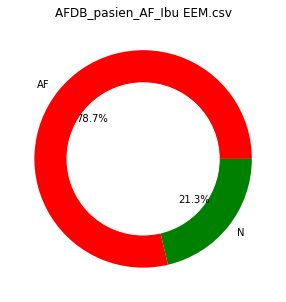

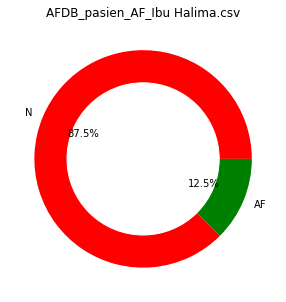

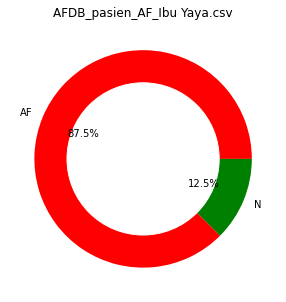

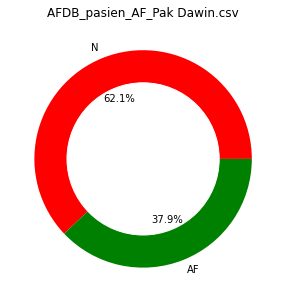

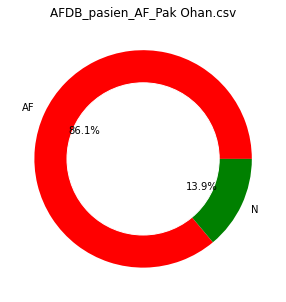

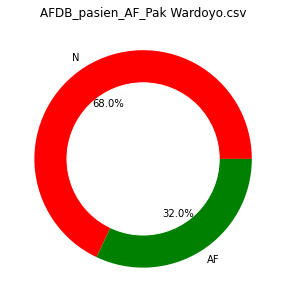

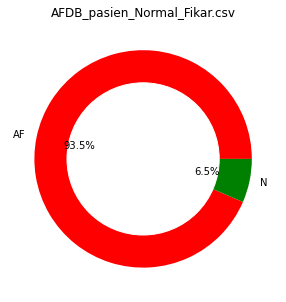

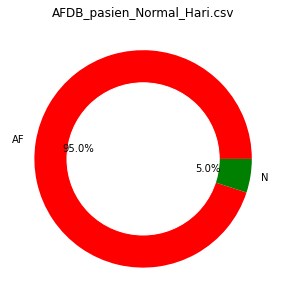

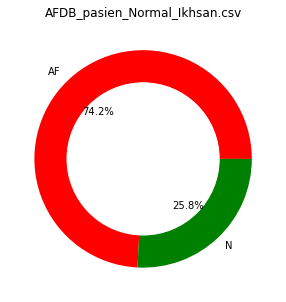

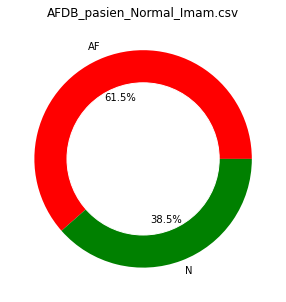

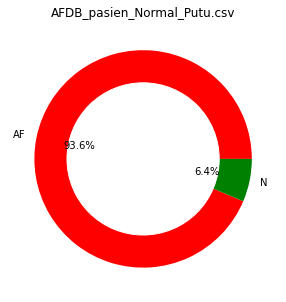

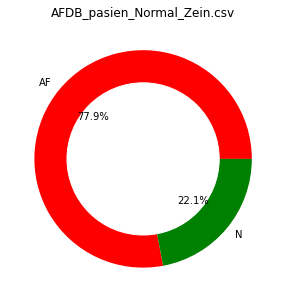

In [33]:
for name in filenames:
    count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
    plot_donat(count.values(), name, count.keys())

- save result as csv

In [53]:
pred_result_df.to_csv(dataset_folder + 'inference_result_cnn_rls_pasien_AF_dan_Normal.csv')